In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"

In [2]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'),0)

tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri3.png'),0)

print(img3.shape)
print(tri3.shape)

(512, 512, 3)
(512, 512)


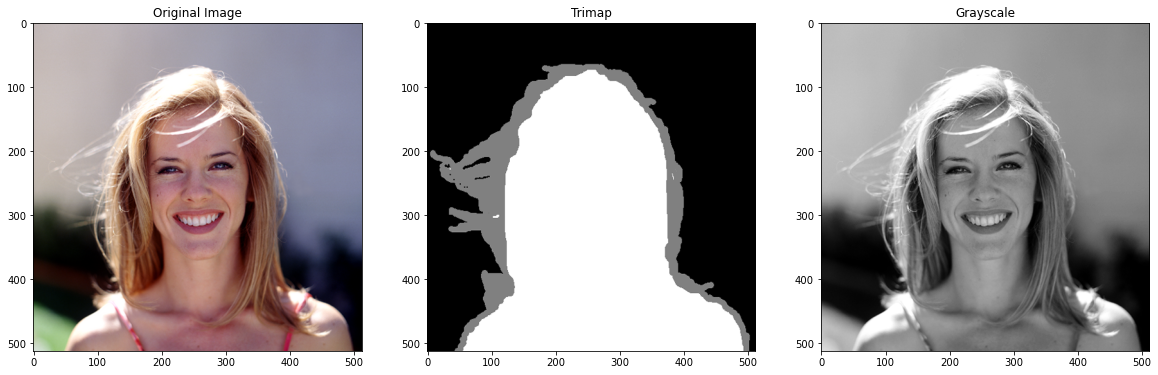

In [3]:
plt.figure(figsize = (20,15))

plt.subplot(131)
plt.imshow(img3)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(tri3,cmap='gray')
plt.title('Trimap')
plt.subplot(133)
plt.imshow(img3_gray,cmap='gray')
plt.title('Grayscale')


plt.show()

(512, 512, 3)


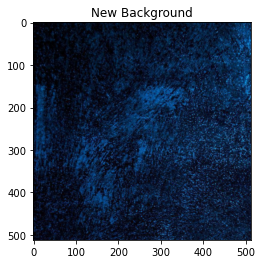

In [4]:
new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg3.png'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = new_bg3[:img3.shape[0],:img3.shape[1],:]
print(new_bg3.shape)
plt.imshow(new_bg3)
plt.title('New Background')
plt.show()

# Global Matting

In [5]:
mask_bg = (tri3<10)
mask_fg = (tri3>245)
mask_unknown = (np.bitwise_and(tri3>=10,tri3<=245))

# mask_unknown = True ^ (mask_bg+mask_fg)

fg = img3_gray*(mask_fg)
bg = img3_gray*(mask_bg)
unknown = img3_gray*mask_unknown

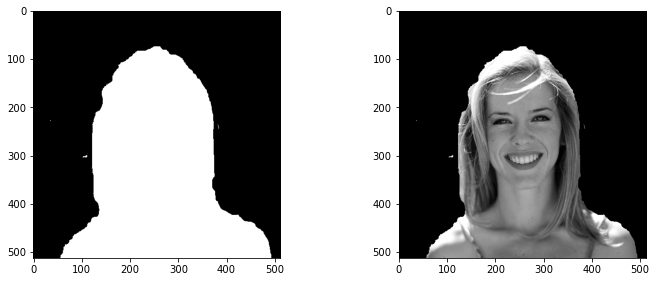

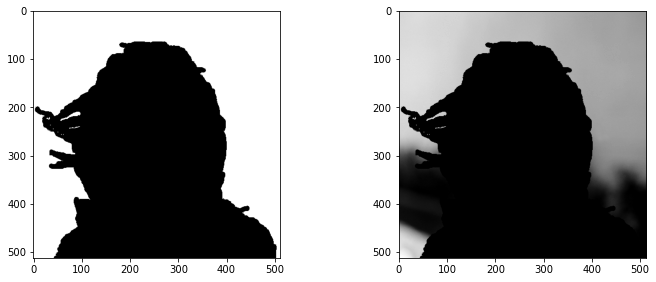

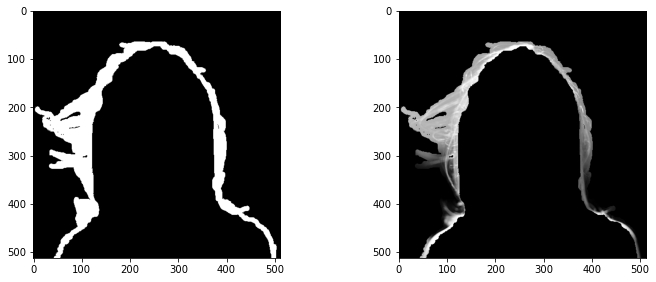

In [6]:
plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_fg,cmap='gray')
plt.subplot(222)
plt.imshow(fg,cmap='gray')
plt.show()

plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_bg,cmap='gray')
plt.subplot(222)
plt.imshow(bg,cmap='gray')
plt.show()

plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_unknown,cmap='gray')
plt.subplot(222)
plt.imshow(unknown,cmap='gray')
plt.show()

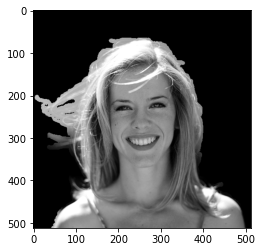

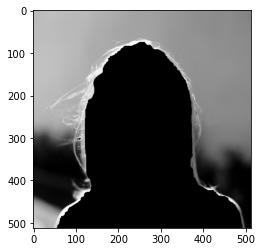

In [7]:
F = img3_gray*(mask_fg+mask_unknown)
B = img3_gray*(mask_bg+mask_unknown)

diff = np.minimum(np.maximum(F-B,0),255)

diff = ndimage.filters.gaussian_filter(diff, 0.9)
diff = np.minimum(np.maximum(diff,0),255)

plt.imshow(F,cmap='gray')
plt.show()
plt.imshow(B,cmap='gray')
plt.show()
# IF possible add a personal Gaussian filter in the next line
# diff = cv2.GaussianBlur(diff,(5,5),cv2.BORDER_DEFAULT)

In [8]:
grad_y,grad_x = np.gradient(img3_gray)

# ###################### Doubtful line
diff[diff==0] = 1

d2y_alpha, _ = np.gradient(grad_y/diff)
_, d2x_alpha = np.gradient(grad_x/diff)

In [9]:
d2alpha = d2y_alpha + d2x_alpha

In [10]:
estimate_alpha = mask_fg + 0.5*mask_unknown


In [11]:
def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 75, threshold = 0.2, beta = 1):
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
                        
    return alpha

In [12]:
alpha = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 50, threshold = 0.3, beta = 1.5)
alpha = np.minimum(np.maximum(alpha,0),1)

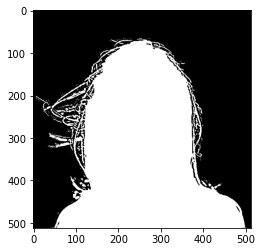

In [13]:
plt.imshow(alpha,cmap='gray')
plt.show()

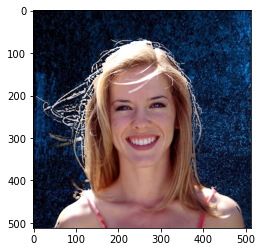

In [14]:

new_img = np.zeros(new_bg3.shape)
new_img[:,:,0] = alpha*img3[:,:,0] + (1-alpha)*new_bg3[:,:,0]
new_img[:,:,1] = alpha*img3[:,:,1] + (1-alpha)*new_bg3[:,:,1]
new_img[:,:,2] = alpha*img3[:,:,2] + (1-alpha)*new_bg3[:,:,2]

plt.imshow(np.int64(new_img),cmap='gray')
plt.show()